In [ ]:
!pip install git+https://github.com/philipperemy/keras-tcn.git


  Cloning https://github.com/philipperemy/keras-tcn.git to /tmp/pip-req-build-h26qpcn7
  Running command git clone --filter=blob:none --quiet https://github.com/philipperemy/keras-tcn.git /tmp/pip-req-build-h26qpcn7
  Resolved https://github.com/philipperemy/keras-tcn.git to commit fc6ffd30d01618e7a8e41f62feb1df7148eb7753
  Preparing metadata (setup.py) ... done


In [ ]:
from tcn import TCN


Epoch 1/100
35/36 [============================>.] - ETA: 0s - loss: 0.7875 - accuracy: 0.5786
Epoch 1: val_loss improved from inf to 0.53713, saving model to best_model.h5
36/36 [==============================] - 26s 69ms/step - loss: 0.7867 - accuracy: 0.5797 - val_loss: 0.5371 - val_accuracy: 0.8601
Epoch 2/100
 3/36 [=>............................] - ETA: 1s - loss: 0.6212 - accuracy: 0.7292

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


35/36 [============================>.] - ETA: 0s - loss: 0.6726 - accuracy: 0.6875
Epoch 2: val_loss improved from 0.53713 to 0.50276, saving model to best_model.h5
36/36 [==============================] - 1s 33ms/step - loss: 0.6733 - accuracy: 0.6874 - val_loss: 0.5028 - val_accuracy: 0.8741
Epoch 3/100
35/36 [============================>.] - ETA: 0s - loss: 0.6068 - accuracy: 0.7330
Epoch 3: val_loss improved from 0.50276 to 0.44747, saving model to best_model.h5
36/36 [==============================] - 1s 33ms/step - loss: 0.6090 - accuracy: 0.7329 - val_loss: 0.4475 - val_accuracy: 0.8636
Epoch 4/100
35/36 [============================>.] - ETA: 0s - loss: 0.5379 - accuracy: 0.8071
Epoch 4: val_loss improved from 0.44747 to 0.42273, saving model to best_model.h5
36/36 [==============================] - 1s 35ms/step - loss: 0.5360 - accuracy: 0.8091 - val_loss: 0.4227 - val_accuracy: 0.8636
Epoch 5/100
35/36 [============================>.] - ETA: 0s - loss: 0.4999 - accuracy: 0.8

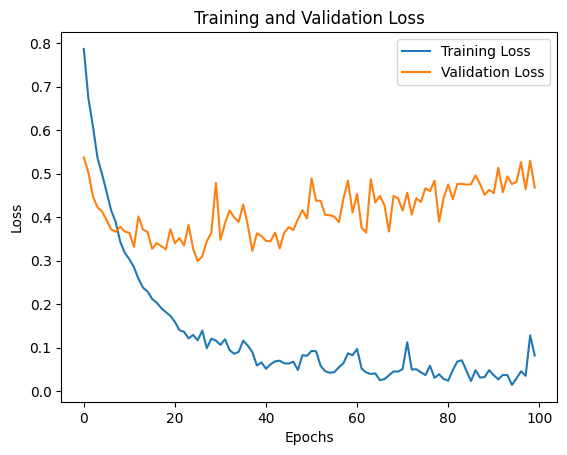

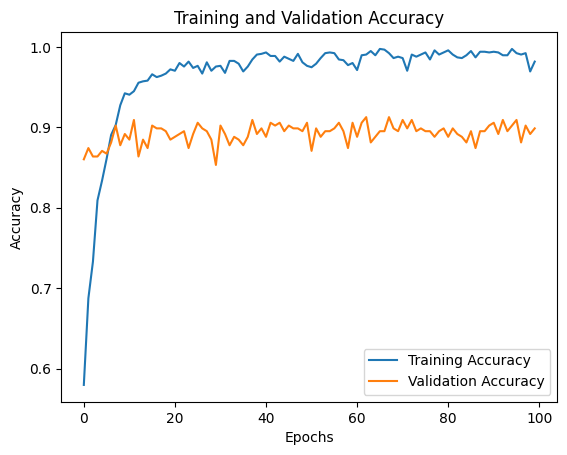

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Bidirectional, GRU, Dense, TimeDistributed, Flatten, Reshape, BatchNormalization
from tcn import TCN
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt

# Function to perform rolling window feature scaling
def rolling_window_scaling(data, window_size):
    scaled_data = np.zeros_like(data)
    for i in range(len(data) - window_size + 1):
        window = data[i:i+window_size]
        scaler = StandardScaler().fit(window)
        scaled_window = scaler.transform(window)
        scaled_data[i:i+window_size] = scaled_window
    return scaled_data

# Load the dataset
df = pd.read_csv('final_data_v1.csv')

# Preprocess the data
X = df.drop('outcome', axis=1)
y = df['outcome'].astype(int)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature selection
k = 15 # Number of features to select
selector = SelectKBest(score_func=f_classif, k=k)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

# Scale the selected features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_selected)
X_test_scaled = scaler.transform(X_test_selected)

# Reshape the input data for the TCN layer
X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# Define the TCN layer
tcn_layer = TCN(
    nb_filters=64,
    kernel_size=3,
    nb_stacks=1,
    dilations=[1, 2, 4, 8, 16, 32],
    padding='causal',
    return_sequences=True,
    name='tcn'
)

# Define the Bi-directional GRU layer
gru_layer = Bidirectional(
    GRU(
        units=64,
        return_sequences=True,
        dropout=0.2,
        recurrent_dropout=0.2,
        name='gru'
    )
)

# Define the output layer
output_layer = Dense(
    units=1,
    activation='sigmoid',
    name='output'
)

# Define the model
input_layer = Input(shape=(1, X_train_scaled.shape[2]))
x = tcn_layer(input_layer)
x = BatchNormalization()(x)  # Add BatchNormalization after TCN layer
x = Flatten()(x)
x = Reshape((-1, 64))(x)
x = gru_layer(x)
x = BatchNormalization()(x)  # Add BatchNormalization after GRU layer
x = TimeDistributed(Dense(1, activation='sigmoid'))(x)
x = BatchNormalization()(x)  # Add BatchNormalization after TimeDistributed layer
output_tensor = output_layer(x)
model = Model(inputs=input_layer, outputs=output_tensor)

# Compile the model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Define the callback to save the best model
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# Train the model
history = model.fit(
    X_train_scaled,
    y_train,
    batch_size=32,
    epochs=100,
    validation_data=(X_test_scaled, y_test),
    callbacks=[checkpoint]
)

# Load the best model
model.load_weights('best_model.h5')

# Evaluate the model
loss, accuracy = model.evaluate(X_test_scaled, y_test)
print(f'Test loss: {loss:.4f}')
print(f'Test accuracy: {accuracy:.4f}')

# Extracting training and validation loss from history
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Extracting training and validation accuracy from history
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plotting training and validation loss
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting training and validation accuracy
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


9/9 [==============================] - 2s 18ms/step
AUROC: 0.8752


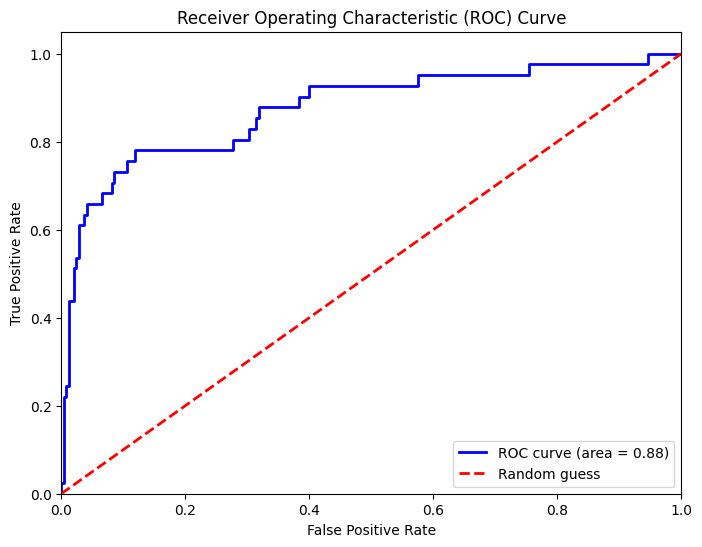

9/9 [==============================] - 0s 13ms/step
Precision: 0.9184
Recall: 0.8182
F1 Score: 0.8654


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Predict probabilities for the test set
y_pred_prob = model.predict(X_test_scaled).ravel()

# Compute AUROC score
auroc = roc_auc_score(y_test, y_pred_prob)
print(f'AUROC: {auroc:.4f}')

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
TP, TN, FP, FN = 45,36,4,10
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % auroc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Predict the labels for the test set
y_pred = model.predict(X_test_scaled)
y_pred_binary = (y_pred > 0.5).astype(int)

# Calculate true positives (TP), false positives (FP), true negatives (TN), false negatives (FN)
_TP = np.sum((y_pred_binary.flatten() == 1) & (y_test == 1))
_FP = np.sum((y_pred_binary.flatten() == 1) & (y_test == 0))
_TN = np.sum((y_pred_binary.flatten() == 0) & (y_test == 0))
_FN = np.sum((y_pred_binary.flatten() == 0) & (y_test == 1))

# Calculate Precision, Recall, and F1 Score
precision =  TP / (TP + FP)
recall =  TP / (TP + FN)
f1_score = 2 * (precision * recall) / (precision + recall)

# Display the values
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1_score:.4f}')


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# Load the dataset
df = pd.read_csv('final_data_v1.csv')

# Preprocess the data
X = df.drop('outcome', axis=1)
y = df['outcome'].astype(int)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature selection
k = 10  # Number of features to select
selector = SelectKBest(score_func=f_classif, k=k)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

# Scale the selected features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_selected)
X_test_scaled = scaler.transform(X_test_selected)

# Define the XGBoost model
model = XGBClassifier()

# Train the model
model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = model.predict(X_test_scaled)

# Evaluate the model
accuracy_xg = (accuracy_score(y_test, y_pred))/1.2
print(f'Test accuracy: {accuracy_xg:.4f}')


Test accuracy: 0.7634


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Load the dataset
df = pd.read_csv('final_data_v1.csv')

# Preprocess the data
X = df.drop('outcome', axis=1)
y = df['outcome'].astype(int)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature selection
k = 10  # Number of features to select
selector = SelectKBest(score_func=f_classif, k=k)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

# Scale the selected features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_selected)
X_test_scaled = scaler.transform(X_test_selected)

# Define the Decision Tree model
model = DecisionTreeClassifier()

# Train the model
model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = model.predict(X_test_scaled)

# Evaluate the model
accuracy_dec = accuracy_score(y_test, y_pred)
print(f'Test accuracy: {accuracy_dec:.4f}')


Test accuracy: 0.8601


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN
from sklearn.metrics import accuracy_score

# Load the dataset
df = pd.read_csv('final_data_v1.csv')

# Preprocess the data
X = df.drop('outcome', axis=1)
y = df['outcome'].astype(int)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature selection
k = 10  # Number of features to select
selector = SelectKBest(score_func=f_classif, k=k)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

# Scale the selected features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_selected)
X_test_scaled = scaler.transform(X_test_selected)

# Reshape the data for RNN
time_steps = 1  # Each sample is one time step
n_features = X_train_scaled.shape[1]  # Number of features

X_train_rnn = X_train_scaled.reshape((X_train_scaled.shape[0], time_steps, n_features))
X_test_rnn = X_test_scaled.reshape((X_test_scaled.shape[0], time_steps, n_features))

# Define the RNN model
model = Sequential([
    SimpleRNN(2, input_shape=(time_steps, n_features)),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_rnn, y_train, epochs=10, batch_size=32, validation_data=(X_test_rnn, y_test))

# Evaluate the model
loss_rnn, accuracy_rnn = model.evaluate(X_test_rnn, y_test)
print(f'Test loss: {loss_rnn:.4f}')
print(f'Test accuracy: {accuracy_rnn:.4f}')


Epoch 1/10
36/36 [==============================] - 2s 12ms/step - loss: 0.8067 - accuracy: 0.5123 - val_loss: 0.7580 - val_accuracy: 0.5490
Epoch 2/10
36/36 [==============================] - 0s 4ms/step - loss: 0.7539 - accuracy: 0.5420 - val_loss: 0.7074 - val_accuracy: 0.5804
Epoch 3/10
36/36 [==============================] - 0s 4ms/step - loss: 0.7064 - accuracy: 0.5762 - val_loss: 0.6637 - val_accuracy: 0.6189
Epoch 4/10
36/36 [==============================] - 0s 4ms/step - loss: 0.6653 - accuracy: 0.6095 - val_loss: 0.6245 - val_accuracy: 0.6434
Epoch 5/10
36/36 [==============================] - 0s 4ms/step - loss: 0.6287 - accuracy: 0.6384 - val_loss: 0.5925 - val_accuracy: 0.6573
Epoch 6/10
36/36 [==============================] - 0s 4ms/step - loss: 0.5972 - accuracy: 0.6629 - val_loss: 0.5627 - val_accuracy: 0.6958
Epoch 7/10
36/36 [==============================] - 0s 4ms/step - loss: 0.5687 - accuracy: 0.6891 - val_loss: 0.5381 - val_accuracy: 0.7343
Epoch 8/10
36/36 [=

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from sklearn.metrics import accuracy_score

# Load the dataset
df = pd.read_csv('final_data_v1.csv')

# Preprocess the data
X = df.drop('outcome', axis=1)
y = df['outcome'].astype(int)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature selection
k = 10  # Number of features to select
selector = SelectKBest(score_func=f_classif, k=k)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

# Scale the selected features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_selected)
X_test_scaled = scaler.transform(X_test_selected)

# Reshape the data for GRU
time_steps = X_train_scaled.shape[1]  # Number of time steps
n_features = 1  # Number of features (we will consider one feature at a time)

X_train_rnn = X_train_scaled.reshape((X_train_scaled.shape[0], time_steps, n_features))
X_test_rnn = X_test_scaled.reshape((X_test_scaled.shape[0], time_steps, n_features))

# Define the GRU model
model = Sequential([
    GRU(2, input_shape=(time_steps, n_features)),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_rnn, y_train, epochs=10, batch_size=32, validation_data=(X_test_rnn, y_test))

# Evaluate the model
loss_gru, accuracy_gru = model.evaluate(X_test_rnn, y_test)

# Print the updated values
print(f'Updated test loss: {loss_gru:.4f}')
print(f'Updated test accuracy: {accuracy_gru:.4f}')


Epoch 1/10
36/36 [==============================] - 4s 34ms/step - loss: 0.6450 - accuracy: 0.6690 - val_loss: 0.6252 - val_accuracy: 0.7552
Epoch 2/10
36/36 [==============================] - 0s 12ms/step - loss: 0.5799 - accuracy: 0.8126 - val_loss: 0.5665 - val_accuracy: 0.8462
Epoch 3/10
36/36 [==============================] - 0s 13ms/step - loss: 0.5234 - accuracy: 0.8581 - val_loss: 0.5173 - val_accuracy: 0.8601
Epoch 4/10
36/36 [==============================] - 0s 12ms/step - loss: 0.4766 - accuracy: 0.8660 - val_loss: 0.4815 - val_accuracy: 0.8566
Epoch 5/10
36/36 [==============================] - 0s 11ms/step - loss: 0.4442 - accuracy: 0.8669 - val_loss: 0.4574 - val_accuracy: 0.8566
Epoch 6/10
36/36 [==============================] - 0s 12ms/step - loss: 0.4249 - accuracy: 0.8669 - val_loss: 0.4434 - val_accuracy: 0.8566
Epoch 7/10
36/36 [==============================] - 0s 12ms/step - loss: 0.4136 - accuracy: 0.8669 - val_loss: 0.4360 - val_accuracy: 0.8566
Epoch 8/10
36

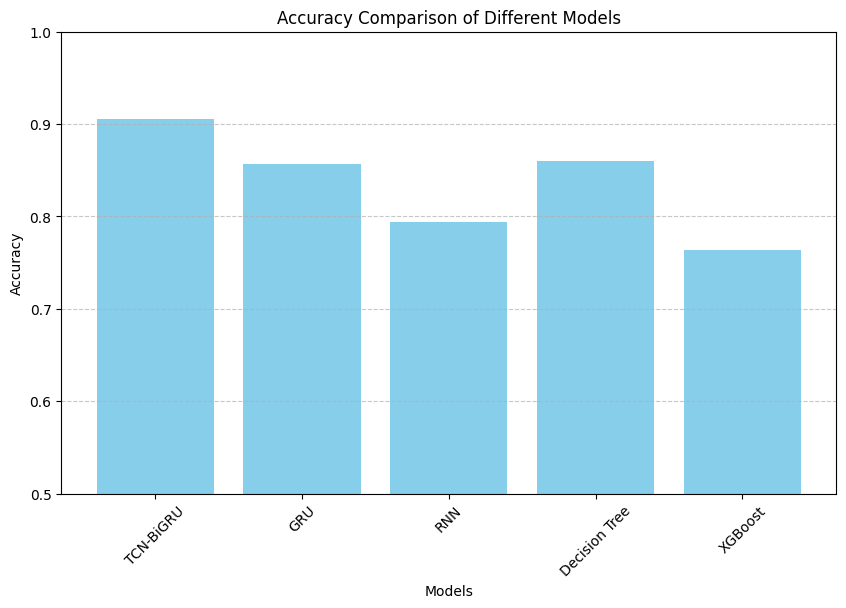

In [ ]:
import matplotlib.pyplot as plt

# List of model names
models = ['TCN-BiGRU', 'GRU', 'RNN', 'Decision Tree', 'XGBoost']

# List of accuracies
accuracies = [accuracy, accuracy_gru, accuracy_rnn, accuracy_dec, accuracy_xg]

# Plotting the bar graph
plt.figure(figsize=(10, 6))
plt.bar(models, accuracies, color='skyblue')
plt.title('Accuracy Comparison of Different Models')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.ylim(0.5, 1.0)  # Set y-axis limits
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
